# Mean-Variance Optimization
This notebook explores mean-variance optimization to construct optimally risky portfolios using the S&P 500 as the selectable set of assets. Part one creates three portfolios, combining long/short and non-leverage/leverage. The end of part one concludes with plotting the efficient frontier and capital allocation line for the long-only non-leveraged portfolio. Part two of the notebook backtests the long-only portfolio to simulate its historic performance. Part three of the notebook concludes with an inquiry surrounding the quality of expected return measurements, and how it affects the mean-variance optimization model. This notebook uses the data extracted from 'data/data.csv'. This CSV file contains 10 years worth (2015-2025) of S&P 500 constituent data. It is important to note that the constituents for the index are from 2025, hence there exists a level of survivorship bias in the following results.

### Preface: Extracting Data
Before exploring mean-variance optimization, the notebook imports the required libraries, extracts and downloads the necessary data, and finally cleans and plots the data.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from scipy.optimize import minimize

# Settings
plt.style.use('ggplot')

In [2]:
# Extract the stock the data
stock_data = pd.read_csv('data/data.csv')
stock_data.set_index('Date', inplace=True)

# Convert to float
stock_data = stock_data.astype(float)

# Convert index to datetime
stock_data.index = pd.to_datetime(stock_data.index)

In [3]:
# Download 1M US T-Bill interest rate data (risk-free rate)
# Convert the data to percentages
rf_data = yf.download('^IRX', start=stock_data.index[0], end=stock_data.index[-1], auto_adjust=True)['Close'] / 100

# Set the margin rate for borrowing
borrow_rate = rf_data.iloc[-1]['^IRX'] + 0.025

[*********************100%***********************]  1 of 1 completed


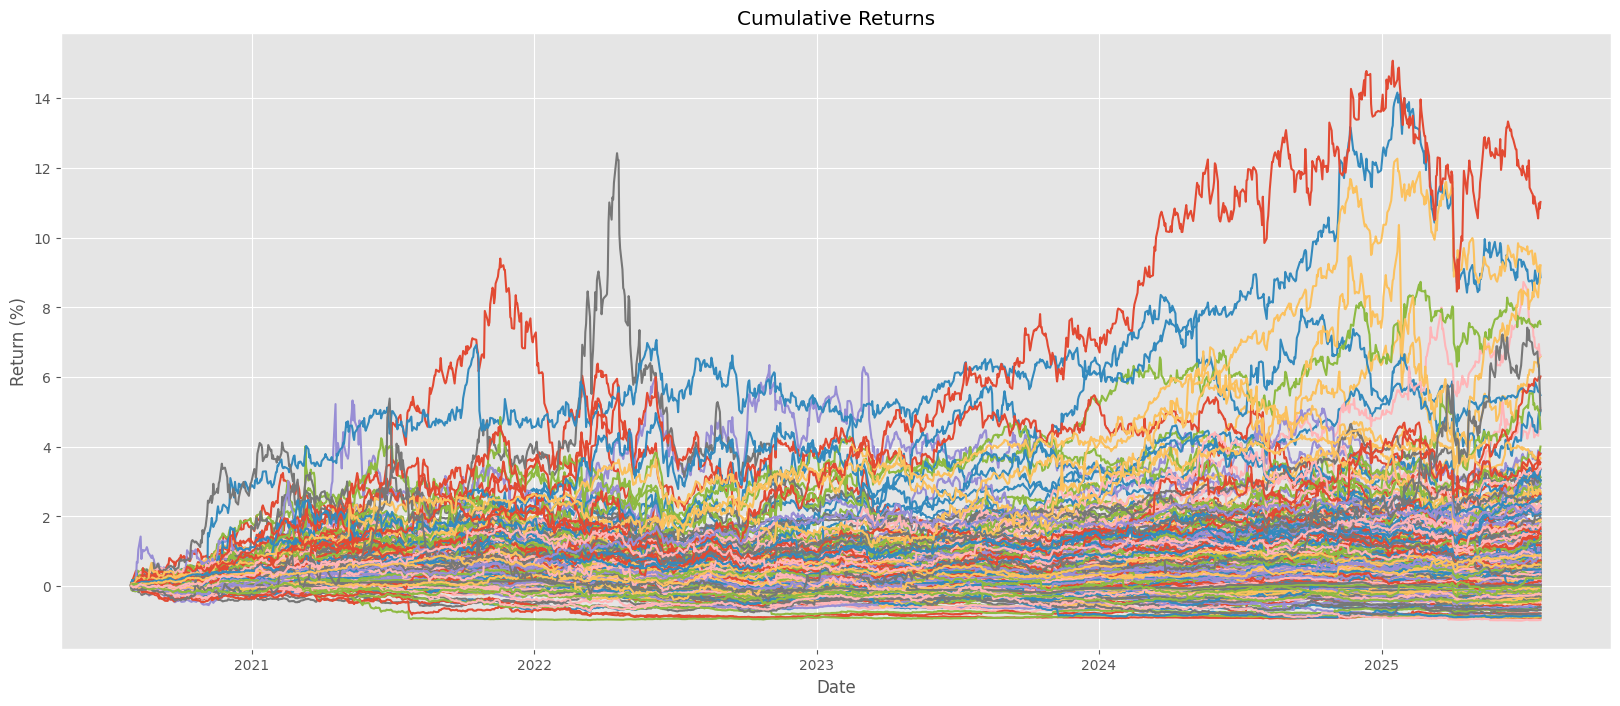

In [4]:
# Use only the past 5 years of data for the test portfolios
N = 252 * 5
train_data = stock_data.iloc[N:]

# Calculate the daily returns
returns = train_data.pct_change(fill_method=None)

# Clean the daily and cumulative returns
# Keeping only the full return series
returns = returns.iloc[1:].dropna(axis=1)
cumulative_returns = (1 + returns).cumprod() - 1

plt.figure(figsize=(20, 8))
plt.plot(cumulative_returns.index, cumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.grid(True)
plt.show()

### Part 1: Optimally Risky Portfolios
Mean-variance optimization was an idea developed by Harry Markowitz to construct an optimally risky portfolio. Assuming a stock's return distribution is normal (questionable), it can be completely be characterized by its mean (expectation) and standard deviation. The objective of the procedure is to find the portfolio (P) with the highest Sharpe ratio $S_P$.<br>
$S_P=\frac{E[r_P]-r_f}{\sigma_P}$ where,
<br>
<br>
$r_f$ = risk-free rate
<br>
$E[r_P]=\sum_{i=1}^{N} w_i*E[r_i]$
<br>
$\sigma_P^2=w*\Sigma*w^T$ where,
<br>
w - list of portfolio weights<br>
$\Sigma$ - covariance matrix of component returns
<br>
<br>
The objective for the constrained maximization is then given by,
<br>
$\max_{w} S_P$
<br>
<br>
The constraint and bounds of the optimization can be changed depending on the portfolio's objectives. Some examples of bounds and constraints are:<br>
$w_i\exists (0,1)$ for long-only bounds<br>
$w_i\exists (-1,1)$ for long-short bounds<br>
$\sum_{i=1}^{N}w_i = 1$ for non-leveraged long only portfolios<br>
$\sum_{i=1}^{N}w_i = 1.5$ for leveraged long only portfolios<br>
$\sum_{i=1}^{N}|w_i| = 1.5$ for long-short portfolios
<br>
<br>
The following sections create four portfolios with different optimization bounds and constraints.
* Portfolio 1: Long only, non-leveraged
* Portfolio 2: Long only, leveraged
* Portfolio 3: Long-Short (leveraged because of margin account requirements)

In [5]:
def portfolio_er(weights, er):
    """
    * Computes the expected return of the portfolio given the
    * component weights and individual expected returns.
    *
    * weights: list of component weights
    * er: list of expected returns
    * NOTE: index of weights and er must match; dimensionality
    *       must match
    *
    * return: portfolio expected return (E[p])
    """

    return np.dot(np.array(weights), np.array(er))

def portfolio_var(weights, cov_matrix):
    """
    * Computes the variance of the portfolio given the component
    * weights and the covariance matrix.
    *
    * weights: list of component weights
    * cov_matrix: matrix of covariances between the individual
    *             components; diagonals are variances
    * NOTE: index of weights and cov_matrix must match; dimensionality
    *       must match
    *
    * return: portfolio variance (Var(p))
    """

    return np.dot(weights, np.dot(cov_matrix, weights.T))

In [6]:
# Optimization Objective Function
def negative_sharpe_ratio(weights, er, cov_matrix, rate=0.025):
    """
    * Computes the negative Sharpe ratio for a portfolio of components.
    * The negative prefix in this calculation is used to convert the
    * minimzation problem into an maximization problem.
    *
    * weights: list of component weights
    * er: list of component expected returns
    * cov_matrix: matrix of covariances between the individual
    *             components; diagonals are variances
    * rate: interest rate to calculate excess return
    * NOTE: index of each input parameter must be equivalent; dimensionality
    *       must match
    *
    * return: negative portfolio Sharpe ratio
    """

    return -(portfolio_er(weights, er) - rate) / np.sqrt(portfolio_var(weights, cov_matrix))

In [7]:
def optimization_results(res, tickers, rate):
    """
    * Prints and plots the optimization results.
    *
    * res: optimization result object
    * tickers: list of tickers that were used in the optimization
    * rate: current risk-free rate
    """

    # Extract the optimized weights
    optimized_weights = res.x
    portfolio_weights = dict(zip(tickers, optimized_weights))

    # Filter only stocks with a +/- 1% or larger portfolio weight
    filtered_weights = {k: v for k, v in portfolio_weights.items() if abs(v) >= 0.01}

    # Total portfolio leverage
    gross_leverage = sum([abs(w) for w in optimized_weights])

    # Print the results (expected portfolio performance)
    print(f'Optimized Weights(filtered): {filtered_weights}')
    print(f'Portfolio Size(filtered): {len(filtered_weights)}')
    print(f'Portfolio Expected Return: {portfolio_er(res.x, expected_returns)}')
    print(f'Portfolio Standard Deviation: {np.sqrt(portfolio_var(res.x, covariance_matrix))}')
    print(f'Portfolio Sharpe Ratio: {-negative_sharpe_ratio(res.x, expected_returns, covariance_matrix, rate=rate)}')
    print(f'Gross Portfolio Leverage: {round(gross_leverage, 5)}')

    # Plot the portfolio weights
    plt.figure(figsize=(20, 8))
    plt.bar(filtered_weights.keys(), filtered_weights.values())
    plt.title("Portfolio Weights (Filtered)")
    plt.xlabel("Ticker")
    plt.ylabel("Weight")
    plt.show()

True
Optimization terminated successfully
Optimized Weights(filtered): {'AGX': 0.07208369677897956, 'ANET': 0.08887007852964249, 'CAH': 0.09725830540677877, 'FINV': 0.013295817144828201, 'GLP': 0.1717492042057381, 'HCI': 0.029709347045766193, 'IBN': 0.08545956503296893, 'K': 0.017068058358519784, 'ODC': 0.11307571480584165, 'TRGP': 0.14807754481066324, 'VEL': 0.04265879928406587, 'VIST': 0.07292152803772156, 'WELL': 0.018533073359231666}
Portfolio Size(filtered): 13
Portfolio Expected Return: 0.43796195181408076
Portfolio Standard Deviation: 0.19523679837705515
Portfolio Sharpe Ratio: 2.0258063861232207
Gross Portfolio Leverage: 1.0


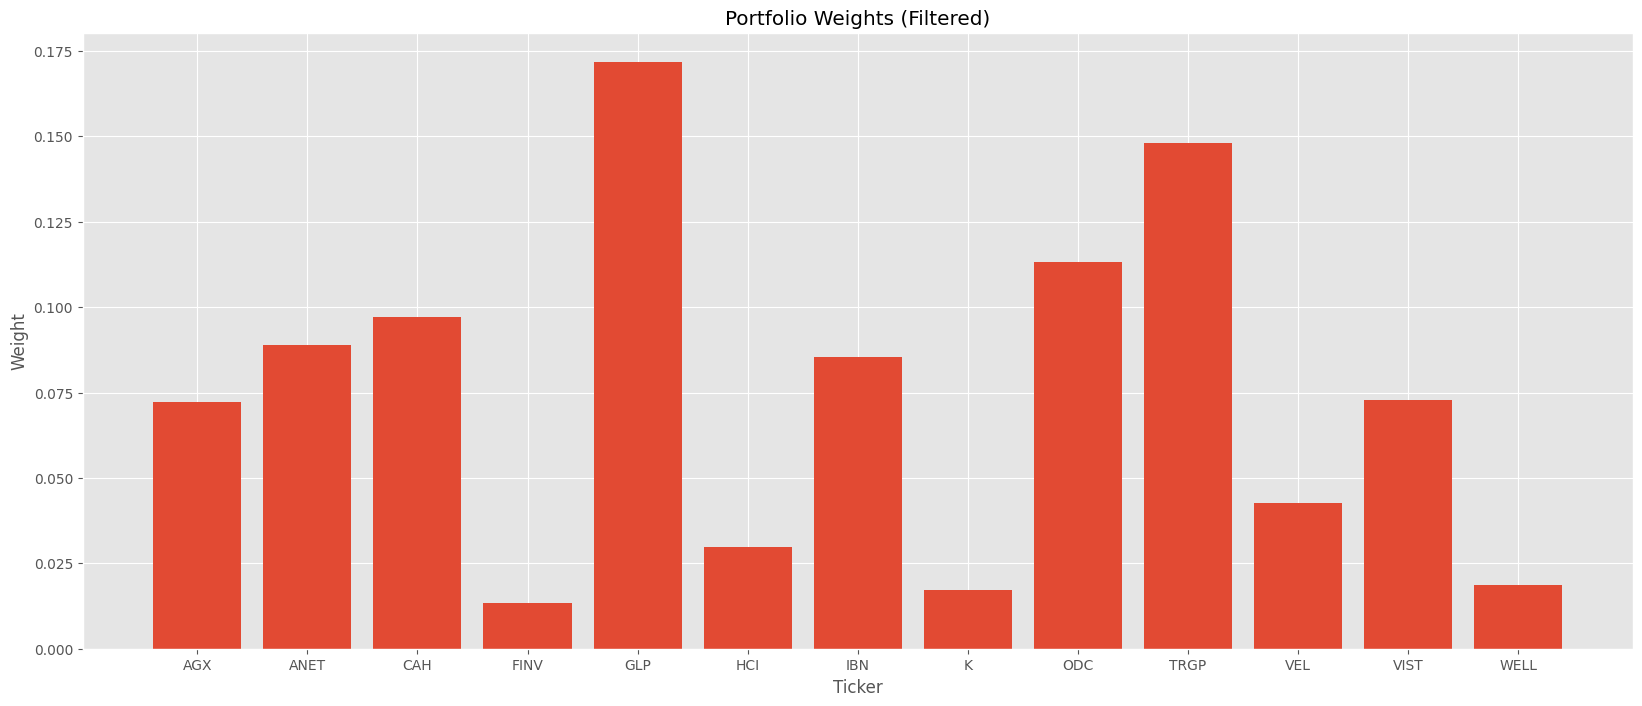

In [8]:
# Mean-Variance Optimization (long-only, non-leveraged)
# SLSQP - Sequential least squares quadratic programming
method = "SLSQP"
weights = [1 / len(returns.columns)] * len(returns.columns)

# Compute the component covariance matrix and expected returns
covariance_matrix = returns.cov() * 252
expected_returns = (1 + returns).prod() ** (252 / len(returns)) - 1

# Allows for long only positions
# Constraining the net portfolio exposure to 1 (non-leveraged)
constraint = {
    'type' : 'eq',                  # Equivalency constraint
    'fun' : lambda w: 1 - np.sum(w) # Sum of all weights equals 1
}
bounds = [(0, 1)] * len(weights)    # Each weight is between 0 and 1

# Maximization
portfolio1_res = minimize(negative_sharpe_ratio,
                 weights,
                 args = (expected_returns, covariance_matrix, rf_data.iloc[-1]['^IRX']),
                 method = method,
                 bounds = bounds,
                 constraints = [constraint])

print(portfolio1_res.success)
print(portfolio1_res.message)

# Print and plot the optimization results
optimization_results(portfolio1_res, returns.columns, rf_data.iloc[-1]['^IRX'])

True
Optimization terminated successfully
Optimized Weights(filtered): {'AGX': 0.10883505185216705, 'ANET': 0.13428634922117602, 'CAH': 0.14505023995293773, 'FINV': 0.019935012727171596, 'GLP': 0.26057010241524325, 'HCI': 0.044781339132890785, 'IBN': 0.12697303886226663, 'K': 0.01737379273932643, 'ODC': 0.1702609143408899, 'TRGP': 0.2255245509020466, 'VEL': 0.0642814686705017, 'VIST': 0.11065464722212325, 'WELL': 0.027167502199035905, 'XYF': 0.01458799450814403}
Portfolio Size(filtered): 14
Portfolio Expected Return: 0.6616324953654074
Portfolio Standard Deviation: 0.2951775623180855
Portfolio Sharpe Ratio: 2.012966337426153
Gross Portfolio Leverage: 1.5


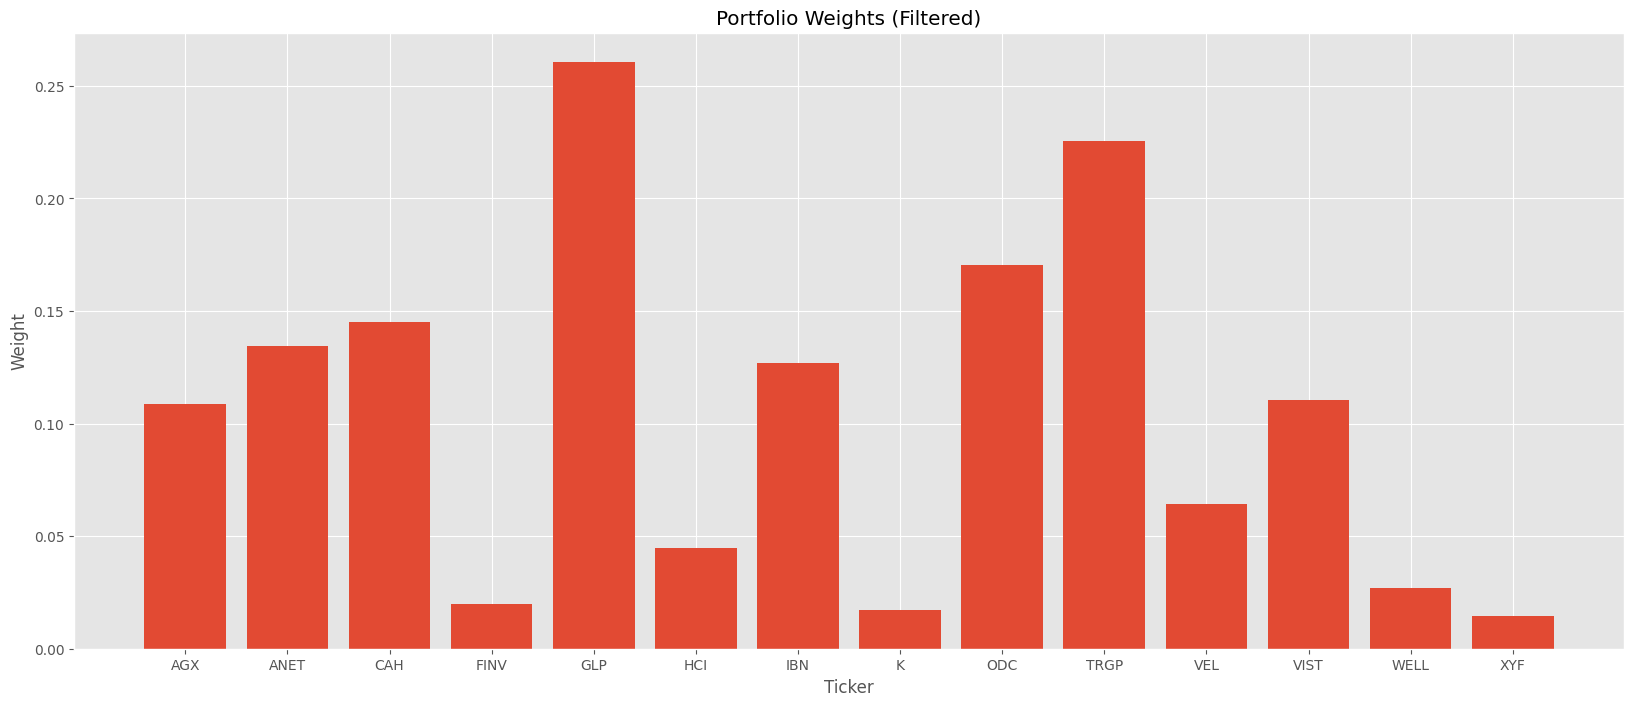

In [9]:
# Mean-Variance Optimization (long-only, leveraged)
# SLSQP - Sequential least squares quadratic programming
method = "SLSQP"
weights = [1 / len(returns.columns)] * len(returns.columns)

# Allows for long only positions
# Allowing for 1.5x gross leverage
constraint = {
    'type' : 'eq',                    # Equivalency constraint
    'fun' : lambda w: 1.5 - np.sum(w) # Sum of all weights equals 1
}
bounds = [(0, 1)] * len(weights)    # Each weight is between 0 and 1

# Maximization
portfolio2_res = minimize(negative_sharpe_ratio,
                 weights,
                 args = (expected_returns, covariance_matrix, borrow_rate),
                 method = method,
                 bounds = bounds,
                 constraints = [constraint])

print(portfolio2_res.success)
print(portfolio2_res.message)

# Print and plot the optimization results
optimization_results(portfolio2_res, returns.columns, borrow_rate)

True
Optimization terminated successfully
Optimized Weights(filtered): {'AGX': 0.03344439173573615, 'ANET': 0.03196700132896707, 'AXL': -0.0307383878416736, 'BLDR': 0.013012644212049168, 'BRW': 0.16798375557416392, 'CABO': -0.012043302641649257, 'CAH': 0.04797184795523676, 'CLB': -0.049213180303480264, 'CSL': 0.018561350674910063, 'CUBB': 0.018644254722654796, 'ERJ': 0.016847802551594, 'FINV': 0.014038628703868624, 'FRA': 0.06461412329003831, 'FSLY': -0.023267786453021806, 'GDL': 0.23889547863370186, 'GLP': 0.06728682374364732, 'GPMT': -0.03194926373774636, 'HCI': 0.024328896073876553, 'IBN': 0.05688306495712989, 'JNJ': 0.010907798462456462, 'K': 0.04021501391874527, 'MED': -0.02063317926628438, 'MIN': 0.027777958793976484, 'ODC': 0.062305719481458854, 'PBH': 0.017686226269504328, 'PJT': 0.01715908226577809, 'PRLB': -0.010607861120777436, 'R': 0.020121053547577955, 'TRGP': 0.08153998160269164, 'TROX': -0.016227360004138897, 'TVC': 0.036185108457632266, 'VEL': 0.019770343866431637, 'VIS

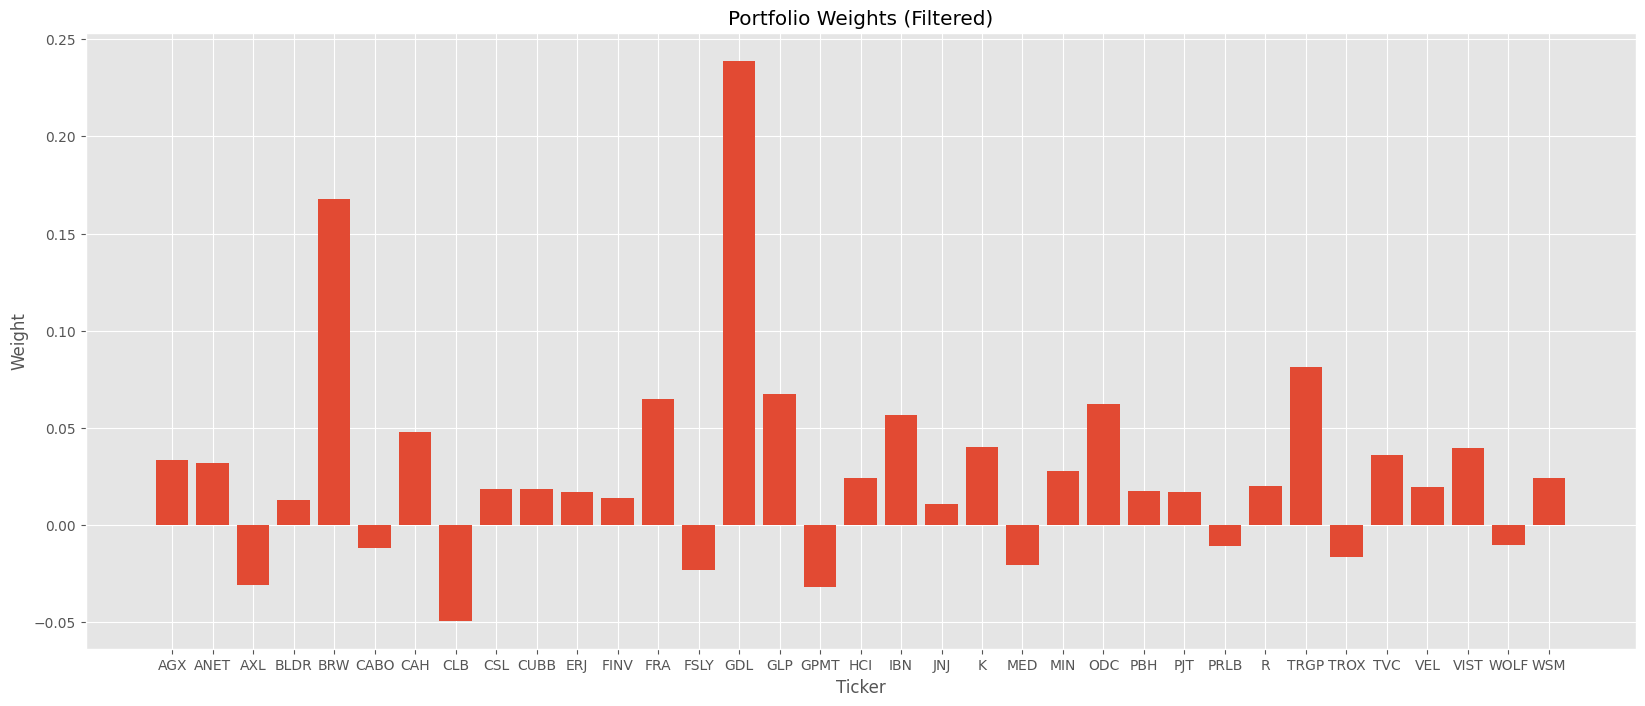

In [10]:
# Mean-Variance Optimization (long-short)
# SLSQP - Sequential least squares quadratic programming
method = "SLSQP"
weights = [1 / len(returns.columns)] * len(returns.columns)

# Allows for long and short positions
constraints = [
    {'type' : 'eq', 'fun' : lambda w: np.sum(w) - 1},
    {'type' : 'ineq', 'fun' : lambda w: 1.5 - np.sum(np.abs(w))}
]

bounds = [(-1, 1)] * len(weights) # Each weight is between -1 and 1

# Maximization
portfolio3_res = minimize(negative_sharpe_ratio,
                 weights,
                 args = (expected_returns, covariance_matrix, borrow_rate),
                 method = method,
                 bounds = bounds,
                 constraints = constraints,
                 options = {'maxiter' : 10_000})

# Print optimization results
print(portfolio3_res.success)
print(portfolio3_res.message)

# Print and plot the optimization results
optimization_results(portfolio3_res, returns.columns, borrow_rate)

Observing the results from the three portfolios, the long-short portfolio has the highest Sharpe ratio. The long-only leverage and non-leverage portfolios exhibit very similar results.

### Part 2: Backtest
To further explore the long-only (non-leveraged) optimization results, part two simulates the performance over the past 6+ years (using a 3 year lookback period). The prospects for business earnings change over time, hence the historical estimation of expected returns should be updated to reflect the earnings expectations. A 3 year lookback period was chosen to estimate the expected return on a historical basis. The backtest compares monthly and annual rebalancing.

[*********************100%***********************]  1 of 1 completed

Portfolio CAGR: 16.4526%
Portfolio Sharpe Ratio: 0.8588
SPY CAGR: 14.2498%
SPY Sharpe Ratio: 0.7630


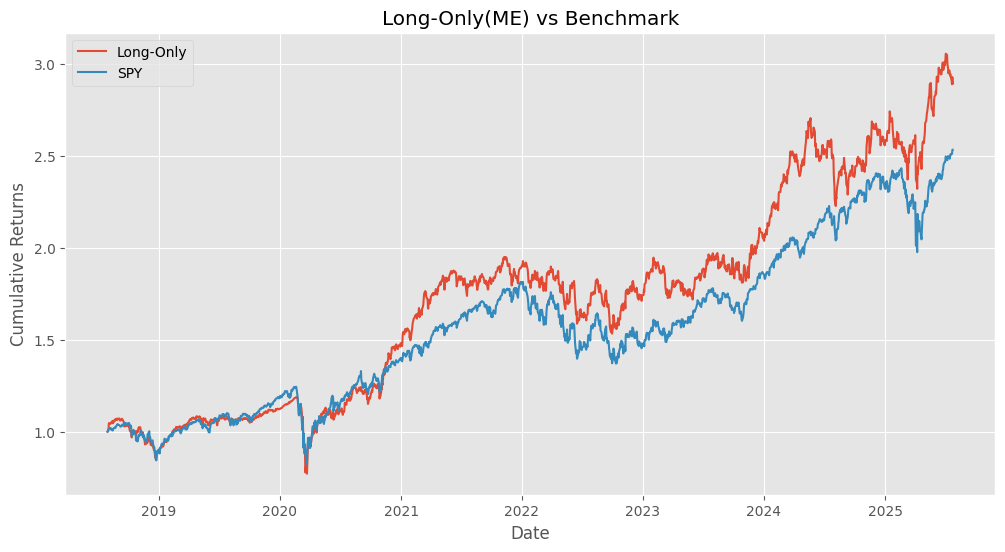

In [11]:
LOOKBACK = 252 * 3 # 3 Years

# Calculate the daily returns
data = stock_data.pct_change(fill_method=None)
monthly_rebalance_dates = data.resample('ME').last().index # Month-end rebalancing

# Optimization parameters (long-only)
method = "SLSQP"
constraint = {
    'type' : 'eq',                  # Equivalency constraint
    'fun' : lambda w: 1 - np.sum(w) # Sum of all weights equals 1
}

portfolio_tickers = []
portfolio_weights = []
daily_returns = [0]

for i in range(len(data)):
    # Check if rebalance
    date = data.index[i]

    if date in monthly_rebalance_dates and i >= LOOKBACK:
        train_data = data.iloc[i-LOOKBACK : i].dropna(axis=1)

        portfolio_tickers = train_data.columns

        # Set the initial weights and set optimization bounds
        weights = [1 / len(portfolio_tickers)] * len(portfolio_tickers)
        bounds = [(0, 1)] * len(weights)

        covariance_matrix = train_data.cov() * 252
        expected_returns = (1 + train_data).prod() ** (252 / len(train_data)) - 1

        # Run the mean-variance optimization
        result = minimize(negative_sharpe_ratio,
                          weights,
                          args = (expected_returns, covariance_matrix, rf_data.iloc[i]['^IRX']),
                          method = method,
                          bounds = bounds,
                          constraints = [constraint])

        portfolio_weights = result.x

        daily_return = np.dot(portfolio_weights, data.iloc[i][portfolio_tickers])

    else:
        # Calculate the daily return
        if len(portfolio_weights) > 0:
            daily_return = np.dot(portfolio_weights, data.iloc[i][portfolio_tickers])

        else:
            daily_return = None

    # Record the daily return
    daily_returns.append(daily_return)

# Calculate cumulative returns
# Remove the lookback period (None returns)
daily_returns = [r for r in daily_returns if r is not None]

dates = data.index[-len(daily_returns):]
daily_returns_series = pd.Series(daily_returns, index=dates)
cumulative_returns = (1 + daily_returns_series).cumprod()

# Performance metrics
total_days = len(daily_returns_series)
cagr = (cumulative_returns.iloc[-1]) ** (252 / total_days) - 1
sharpe_ratio = (daily_returns_series.mean() * 252) / (daily_returns_series.std() * np.sqrt(252))

# Calculate the returns for the benchmark
spy = yf.download('SPY', start=daily_returns_series.index[0], end=daily_returns_series.index[-1], auto_adjust=True)['Close']
spy_returns = spy.pct_change().fillna(0)
spy_cumulative = (1 + spy_returns).cumprod()

spy_cagr = (spy_cumulative['SPY'].iloc[-1]) ** (252 / total_days) - 1
spy_sharpe = (spy_returns.mean() * 252) / (spy_returns.std() * np.sqrt(252))

print(f"Portfolio CAGR: {cagr:.4%}")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")

print(f"SPY CAGR: {spy_cagr:.4%}")
print(f"SPY Sharpe Ratio: {spy_sharpe['SPY']:.4f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Long-Only")
plt.plot(spy_cumulative, label="SPY")
plt.title("Long-Only(ME) vs Benchmark")
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed

Portfolio CAGR: 16.7044%
Portfolio Sharpe Ratio: 0.8857
SPY CAGR: 17.2041%
SPY Sharpe Ratio: 0.8875


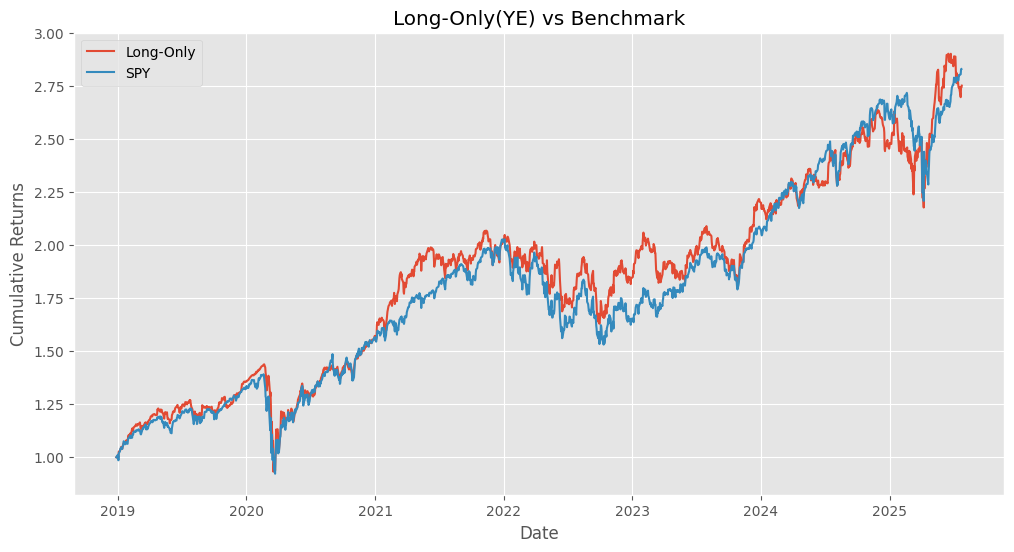

In [12]:
LOOKBACK = 252 * 3 # 3 Years

# Calculate the daily returns
data = stock_data.pct_change(fill_method=None)
annual_rebalance_dates = data.resample('YE').last().index # Year-end rebalancing

# Optimization parameters (long-only)
method = "SLSQP"
constraint = {
    'type' : 'eq',                  # Equivalency constraint
    'fun' : lambda w: 1 - np.sum(w) # Sum of all weights equals 1
}

portfolio_tickers = []
portfolio_weights = []
daily_returns = [0]

for i in range(len(data)):
    # Check if rebalance
    date = data.index[i]

    if date in annual_rebalance_dates and i >= LOOKBACK:
        train_data = data.iloc[i-LOOKBACK : i].dropna(axis=1)

        portfolio_tickers = train_data.columns

        # Set the initial weights and set optimization bounds
        weights = [1 / len(portfolio_tickers)] * len(portfolio_tickers)
        bounds = [(0, 1)] * len(weights)

        covariance_matrix = train_data.cov() * 252
        expected_returns = (1 + train_data).prod() ** (252 / len(train_data)) - 1

        # Run the mean-variance optimization
        result = minimize(negative_sharpe_ratio,
                          weights,
                          args = (expected_returns, covariance_matrix, rf_data.iloc[i]['^IRX']),
                          method = method,
                          bounds = bounds,
                          constraints = [constraint])

        portfolio_weights = result.x

        daily_return = np.dot(portfolio_weights, data.iloc[i][portfolio_tickers])

    else:
        # Calculate the daily return
        if len(portfolio_weights) > 0:
            daily_return = np.dot(portfolio_weights, data.iloc[i][portfolio_tickers])

        else:
            daily_return = None

    # Record the daily return
    daily_returns.append(daily_return)

# Calculate cumulative returns
# Remove the lookback period (None returns)
daily_returns = [r for r in daily_returns if r is not None]

dates = data.index[-len(daily_returns):]
daily_returns_series = pd.Series(daily_returns, index=dates)
cumulative_returns = (1 + daily_returns_series).cumprod()

# Performance metrics
total_days = len(daily_returns_series)
cagr = (cumulative_returns.iloc[-1]) ** (252 / total_days) - 1
sharpe_ratio = (daily_returns_series.mean() * 252) / (daily_returns_series.std() * np.sqrt(252))

# Calculate the returns for the benchmark
spy = yf.download('SPY', start=daily_returns_series.index[0], end=daily_returns_series.index[-1], auto_adjust=True)['Close']
spy_returns = spy.pct_change().fillna(0)
spy_cumulative = (1 + spy_returns).cumprod()

spy_cagr = (spy_cumulative['SPY'].iloc[-1]) ** (252 / total_days) - 1
spy_sharpe = (spy_returns.mean() * 252) / (spy_returns.std() * np.sqrt(252))

print(f"Portfolio CAGR: {cagr:.4%}")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")

print(f"SPY CAGR: {spy_cagr:.4%}")
print(f"SPY Sharpe Ratio: {spy_sharpe['SPY']:.4f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Long-Only")
plt.plot(spy_cumulative, label="SPY")
plt.title("Long-Only(YE) vs Benchmark")
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

### Part 3: Expected Return Estimation Quality
The two inputs into the mean-variance optimization model are estimates of expected return and covariance among components. Using historical estimates for expected return and covariance has a clear issue, how can we be sure that past performance will continue into the future? Another way of phrasing this question would be "Would accurate estimates of expected return and covariance lead to superior model performance?". This section explores how the mean-variance optimization model would allocate funds *if* we had a perfect estimate of expected returns and covariance. Using the monthly rebalancing and 3-year lookback backtest, the expected return and covariance estimate is the actual performance over the next one month period. This lookahead is then used to simulate a "perfect" expected return estimate.

[*********************100%***********************]  1 of 1 completed

Portfolio CAGR: 114.5524%
Portfolio Sharpe Ratio: 2.8269


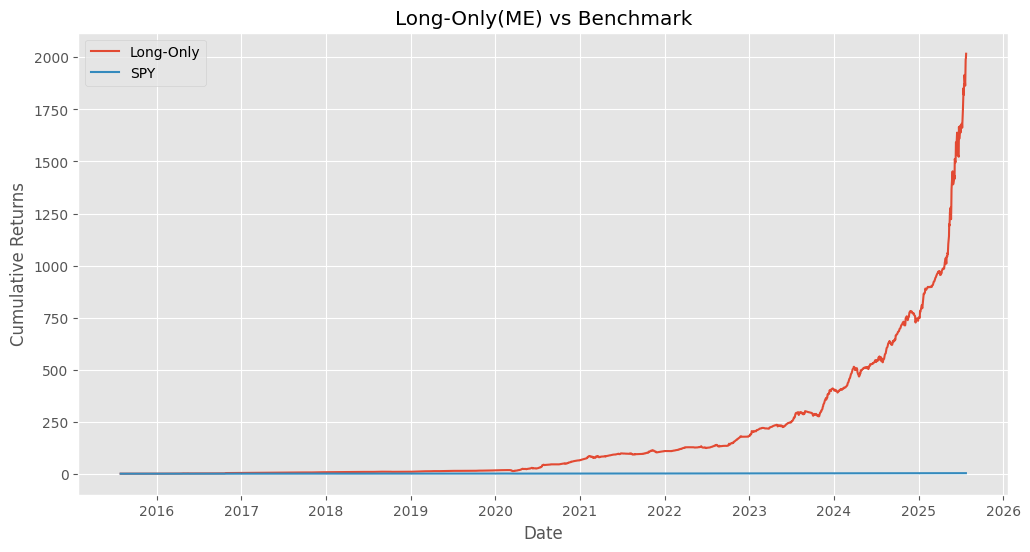

In [13]:
LOOKFORWARD = 20 # 20 trading days in a month

# Calculate the daily returns
data = stock_data.pct_change(fill_method=None)
monthly_rebalance_dates = data.resample('ME').last().index # Month-end rebalancing

# Optimization parameters (long-only)
method = "SLSQP"
constraint = {
    'type' : 'eq',                  # Equivalency constraint
    'fun' : lambda w: 1 - np.sum(w) # Sum of all weights equals 1
}

# Performance tracking
portfolio_tickers = []
portfolio_weights = []
daily_returns = [0]

for i in range(len(data)):
    # Check if rebalance
    date = data.index[i]

    if date in monthly_rebalance_dates and i <= (len(data) - LOOKFORWARD):
        train_data = data.iloc[i : i+LOOKFORWARD].dropna(axis=1)

        portfolio_tickers = train_data.columns

        # Set the initial weights and set optimization bounds
        weights = [1 / len(portfolio_tickers)] * len(portfolio_tickers)
        bounds = [(0, 1)] * len(weights)

        covariance_matrix = train_data.cov() * 252
        expected_returns = (1 + train_data).prod() ** (252 / len(train_data)) - 1

        # Run the mean-variance optimization
        result = minimize(negative_sharpe_ratio,
                          weights,
                          args = (expected_returns, covariance_matrix, rf_data.iloc[i]['^IRX']),
                          method = method,
                          bounds = bounds,
                          constraints = [constraint])

        portfolio_weights = result.x

        daily_return = np.dot(portfolio_weights, data.iloc[i][portfolio_tickers])

    else:
        # Calculate the daily return
        if len(portfolio_weights) > 0:
            daily_return = np.dot(portfolio_weights, data.iloc[i][portfolio_tickers])

        else:
            daily_return = None

    # Record the daily return
    daily_returns.append(daily_return)

# Calculate cumulative returns
# Remove the lookback period (None returns)
daily_returns = [r for r in daily_returns if r is not None]

dates = data.index[-len(daily_returns):]
daily_returns_series = pd.Series(daily_returns, index=dates)
cumulative_returns = (1 + daily_returns_series).cumprod()

# Performance metrics
total_days = len(daily_returns_series)
cagr = (cumulative_returns.iloc[-1]) ** (252 / total_days) - 1
sharpe_ratio = (daily_returns_series.mean() * 252) / (daily_returns_series.std() * np.sqrt(252))

# Calculate the returns for the benchmark
spy = yf.download('SPY', start=daily_returns_series.index[0], end=daily_returns_series.index[-1], auto_adjust=True)['Close']
spy_returns = spy.pct_change().fillna(0)
spy_cumulative = (1 + spy_returns).cumprod()

spy_cagr = (spy_cumulative['SPY'].iloc[-1]) ** (252 / total_days) - 1
spy_sharpe = (spy_returns.mean() * 252) / (spy_returns.std() * np.sqrt(252))

print(f"Portfolio CAGR: {cagr:.4%}")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.4f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Long-Only")
plt.plot(spy_cumulative, label="SPY")
plt.title("Long-Only(ME) vs Benchmark")
plt.ylabel("Cumulative Returns")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

As seen in the *HIGHLY* unrealistic graph above, having perfect estimates for the expected return and covariance matrix pays...